In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import importlib

from mesa.batchrunner import BatchRunner

import src.model

In [2]:
# run this cell to re-import the Model class
importlib.reload(src.model);

# Single run

In [3]:
# setup parameters
time_step = 0.4
n_steps = 1000

model = src.model.Model(
    length = 1000,
    n_lanes = 2,
    density = 30, # cars per 1km lane
    fraction_autonomous = 0, # autonomous vehicles have p_slowdown = 0 and mean values, no error in speed estimation
    max_speed_mu = 120,
    min_spacing = 2,
    min_distance_mu = 2,
    min_distance_min = 1,
    min_distance_max = 3,
    car_acc = 3.333, # m/s^2
    car_dec = 5, # m/s^2
    p_slowdown = 3, # frequency (per hour) of slowing down randomly
    bias_right_lane = 1,
    time_step = time_step,
    seed  = None,
    verbose = 3
    )

# run simulation for `n_steps`
def run():
    for i in range(n_steps):
        model.step()
        
%time run()

Wall time: 18 s


Text(0,0.5,'Flow $k$')

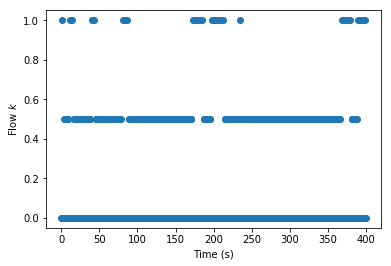

In [4]:
# plot the density over time
df = model.data.get_model_vars_dataframe()
plt.plot(df.index * time_step, df.Flow, "o")
plt.xlabel("Time (s)")
plt.ylabel("Flow $k$")

# Batch run

Note that the `model_reporters` and `agent_reporters` of `BatchRunner` (unlike the `DataCollector`) won’t collect the data every step of the model, but only at the end of each run. Because of this the following function is used to extract the relevant data from the models datacollector.

In [5]:
def get_density(model, initialisation_steps=0):
    """Extract density from model datacollector.
    
    Parameters
    ----------
    model
    initialisation_steps -- number of initial steps to exclude from the mean.
    """
    # time-evolution of density
    densities = model.data.get_model_vars_dataframe().Density
    # return the mean
    return densities[initialisation_steps:].mean()
    
def get_flow(model, initialisation_steps=0, flow_per=10):
    """Extract flow from model datacollector.
    
    Parameters
    ----------
    model
    initialisation_steps -- number of initial steps to exclude from the mean.
    flow_per -- return the flow per this number of time_steps.
    """
    # time-evolution of flow
    flows = model.data.get_model_vars_dataframe().Flow
    # return the mean
    return flows[initialisation_steps:].mean() * flow_per

In [7]:
# setup parameters
n_lanes = [2, 3, 4]
density = np.linspace(10, 35, 20).astype(int)
#fraction_autonomous = np.linspace(0.10, 1, 20)

n_steps = 500 # for analysis = 500
initialisation_steps = 100 # for analysis = 100
iterations = 2 # for analysis = 10

fixed_params = {
    "length": 1000,
    "fraction_autonomous": 0, # autonomous vehicles have p_slowdown = 0 and mean values, no error in speed estimation
    "max_speed_mu": 120,
    "min_spacing": 2,
    "min_distance_mu": 2,
    "min_distance_min": 1,
    "min_distance_max": 3,
    "car_acc": 3.333, # m/s^2
    "car_dec": 5, # m/s^2
    "p_slowdown": 3, # frequency (per hour) of slowing down randomly
    "bias_right_lane": 1,
    "time_step": 0.1,
    "seed" : None,
    "verbose": 3 
}

variable_params = {
    "n_lanes": n_lanes,
    "density": density,
    #"fraction_autonomous": fraction_autonomous
}

# create and run `BatchRunner`
batch_run = BatchRunner(src.model.Model,
                        fixed_parameters=fixed_params,
                        variable_parameters=variable_params,
                        iterations=iterations,
                        max_steps=n_steps,
                        model_reporters={
                            "flow": lambda x: get_flow(x, initialisation_steps)
                        },
                        agent_reporters={},
                        display_progress=True)

print("Total iterations: ", np.product([len(var) for var in batch_run.variable_parameters.values()]) * batch_run.iterations)
sys.stdout.flush()
batch_run.run_all()

Total iterations:  120


120it [23:25, 33.54s/it]


In [8]:
# get the dataframe and select the relevant columns
df = batch_run.get_model_vars_dataframe()
df = df[["length", "n_lanes", "density", "fraction_autonomous", "flow"]]
df.head()

,length,n_lanes,density,fraction_autonomous,flow
0,1000,2,10,0,0.300000
1,1000,2,10,0,0.316667
2,1000,2,11,0,0.366667
3,1000,2,11,0,0.333333
4,1000,2,12,0,0.366667


In [9]:
df

,length,n_lanes,density,fraction_autonomous,flow
0,1000,2,10,0,0.300000
1,1000,2,10,0,0.316667
2,1000,2,11,0,0.366667
3,1000,2,11,0,0.333333
4,1000,2,12,0,0.366667
5,1000,2,12,0,0.366667
6,1000,2,13,0,0.416667
7,1000,2,13,0,0.400000
8,1000,2,15,0,0.383333
9,1000,2,15,0,0.416667


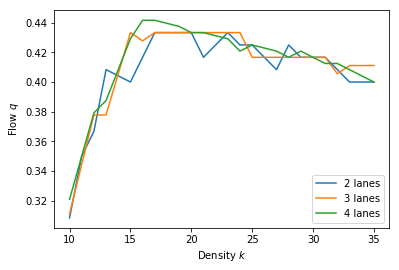

In [16]:
# plot flow rate versus vehicle density 
fig, ax = plt.subplots(1, 1)
for n_lane in n_lanes:
    data = df[df.n_lanes == n_lane]
    ax.plot(data.density[::2], data.groupby(["n_lanes","density"])["flow"].mean(), label="{} lanes".format(n_lane))
    
ax.set_xlabel("Density $k$")
ax.set_ylabel("Flow $q$")    
ax.legend()

# Sensitivity Analysis OFAT

In [17]:
%matplotlib inline
from SALib.sample import saltelli
from src.model import Model
from src.car import Car
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [26]:
# Set the repetitions, the amount of steps, and the amount of distinct values per variable
max_steps = 20 # for analysis = 500
initialisation_steps = 0 # for analysis = 100

distinct_samples = 5 # for analysis = 20
replicates = 10


# We define our variables and bounds
problem = {
    'num_vars': 5,
    'names': ['p_slowdown', 'n_lanes', 'density', 'fraction_autonomous', "max_speed_mu"],
    'bounds': [[1, 6], [2, 4], [10, 35], [0, 1], [100, 130]]
}

fixed_params = {
    "length": 1000,
    "n_lanes": 2,
    "density": 15, # cars per 1km lane
    "fraction_autonomous": 0, # autonomous vehicles have p_slowdown = 0 and mean values, no error in speed estimation
    "max_speed_mu": 120,
    "min_spacing": 2,
    "min_distance_mu": 2,
    "min_distance_min": 1,
    "min_distance_max": 3,
    "car_acc": 3.333, # m/s^2
    "car_dec": 5, # m/s^2
    "p_slowdown": 3, # frequency (per hour) of slowing down randomly
    "bias_right_lane": 1,
    "time_step": 0.4,
    "seed" : None,
    "verbose": 3 
}


# Set the outputs
model_reporters = {"flow": lambda x: get_flow(x, initialisation_steps)}

data = {}

def make_var_param(params, var_name):
    new_params = params
    del new_params[var_name]
    return new_params


for i, var in enumerate(problem['names']):
    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
    
    # Keep in mind that wolf_gain_from_food should be integers. You will have to change
    # your code to acommidate for this or sample in such a way that you only get integers.
    if var == 'n_lanes':
        samples = np.linspace(*problem['bounds'][i], num=5, dtype=int)
    
    fixed_parameters_alt = make_var_param(fixed_params, var)
    
    batch = BatchRunner(Model, 
                        max_steps=max_steps,
                        iterations=replicates,
                        fixed_parameters=fixed_parameters_alt,
                        variable_parameters={var: samples},
                        model_reporters=model_reporters,
                        display_progress=True)
    
    batch.run_all()
    
    data[var] = batch.get_model_vars_dataframe()


50it [00:06,  8.31it/s]
50it [00:09,  3.38it/s]
50it [00:03,  6.66it/s]
50it [00:05,  8.99it/s]
50it [00:05,  8.57it/s]


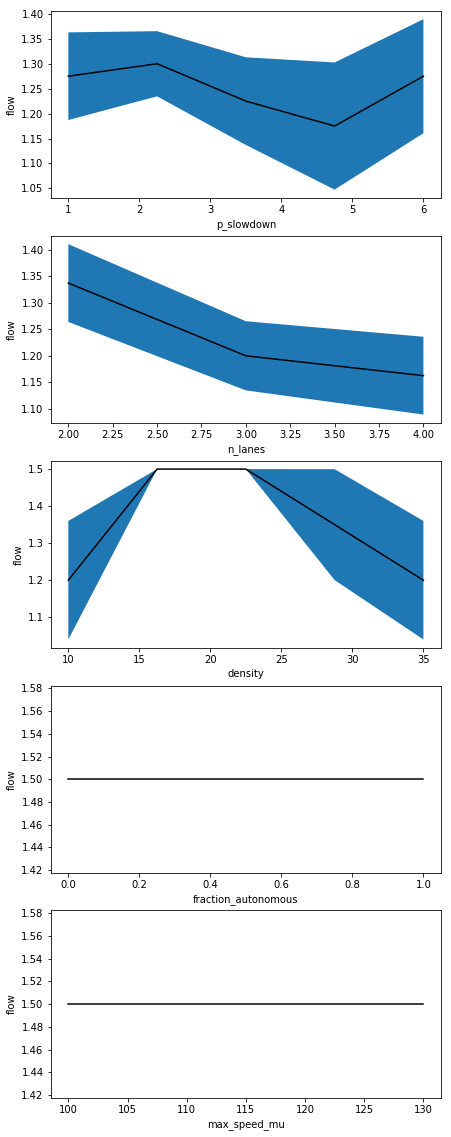

In [27]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(len(problem['names']), figsize=(7, 20))
    
    for i, var in enumerate(problem['names']):
        plot_param_var_conf(axs[i], data[var], var, param, i)

        
## Wat moet hier ... op de plek van 'flow'         
for param in model_reporters:
    plot_all_vars(data, param)
    plt.show()

# Global Sensitivity Analysis

In [28]:
# Set the repetitions, the amount of steps, and the amount of distinct values per variable
max_steps = 20 # for analysis = 500
initialisation_steps = 0 # for analysis = 100

distinct_samples = 5 # for analysis = 20
replicates = 10

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)

In [29]:
from IPython.display import clear_output
fixed_params = {
    "length": 1000,
    #"n_lanes": 2,
    #"density": 15, # cars per 1km lane
    #"fraction_autonomous": 0, # autonomous vehicles have p_slowdown = 0 and mean values, no error in speed estimation
    #"max_speed_mu": 120,
    "min_spacing": 2,
    "min_distance_mu": 2,
    "min_distance_min": 1,
    "min_distance_max": 3,
    "car_acc": 3.333, # m/s^2
    "car_dec": 5, # m/s^2
    #"p_slowdown": 3, # frequency (per hour) of slowing down randomly
    "bias_right_lane": 1,
    "time_step": 0.4,
    "seed" : None,
    "verbose": 3 
}

batch = BatchRunner(Model, 
                    max_steps=max_steps,
                    fixed_parameters=fixed_params,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

count = 0
for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals[1] = int(vals[1])

        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
    
data = batch.get_model_vars_dataframe()

100.00% done


In [31]:
Si_flow = sobol.analyze(problem, data['flow'].as_matrix(), print_to_console=False)

def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """
    print(i)
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

C:\Users\ruuds\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


1


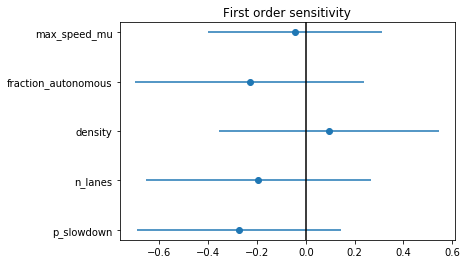

2


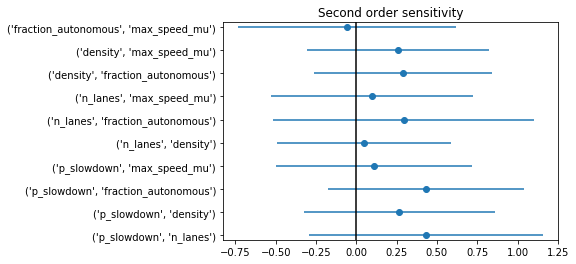

T


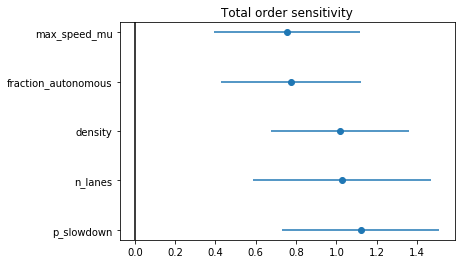

In [32]:
# First order
plot_index({k: Si_flow[k] for k in list(Si_flow)[:2]}, problem['names'], '1', 'First order sensitivity')
plt.show()

# Second order
plot_index({k: Si_flow[k] for k in list(Si_flow)[4:6]}, problem['names'], '2', 'Second order sensitivity')
plt.show()

# Total order
plot_index({k: Si_flow[k] for k in list(Si_flow)[2:4]}, problem['names'], 'T', 'Total order sensitivity')
plt.show()